In [17]:
import penaltyblog as pb
import pandas as pd
import numpy as np
import datetime as dt
import dataframe_image as dfi
from random import choices
import json
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from utils import (simulate_match, analyse_match, table_bonus_check, calculate_manager_points, simulate_season)

pd.set_option('display.max_columns', None)

# Functions

In [ ]:
def simulate_match(clf, homeTeam, awayTeam):
    '''
    Simulate the outcome of a single match.
    '''

    probs = clf.predict(homeTeam, awayTeam)

    # simulate scoreline
    marginal_home = np.sum(probs.grid, axis=1)
    marginal_away = np.sum(probs.grid, axis=0)
    home_goals = choices(np.arange(15), weights=marginal_home)[0]
    away_goals = choices(np.arange(15), weights=marginal_away)[0]

    if home_goals > away_goals:
        outcome = 'home_win'
    elif home_goals == away_goals:   
        outcome = 'draw'
    else:
        outcome = 'away_win'

    return outcome, home_goals, away_goals

In [ ]:
def analyse_match(clf, homeTeam, awayTeam):

    probs = clf.predict(homeTeam, awayTeam)
    display(probs)

    ax = sns.heatmap(probs.grid[:6, :6], annot=True, fmt=".2f")
    ax.set(xlabel=awayTeam, ylabel=homeTeam)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

In [ ]:
def table_bonus_check(focal_team, opponent, league_table):
    focal_team_rank = league_table.loc[league_table.Squad==focal_team, 'Rk'].values[0]
    opponent_rank = league_table.loc[league_table.Squad==opponent, 'Rk'].values[0]
    if focal_team_rank - opponent_rank >= 5:
        return 1.0
    else:
        return 0.0

# Data

In [2]:
fb = pb.scrapers.FootballData("ENG Premier League", "2023-2024")
df_list = [fb.get_fixtures()]
fb = pb.scrapers.FootballData("ENG Premier League", "2024-2025")
df_list.append(fb.get_fixtures())

df = pd.concat(df_list)
display(df)

,date,datetime,season,competition,div,time,team_home,team_away,fthg,ftag,ftr,hthg,htag,htr,referee,hs,as,hst,ast,hf,af,hc,ac,hy,ay,hr,ar,b365_h,b365_d,b365_a,bwh,bwd,bwa,iwh,iwd,iwa,psh,psd,psa,whh,whd,wha,vch,vcd,vca,max_h,max_d,max_a,avg_h,avg_d,avg_a,b365>2.5,b365<2.5,p>2.5,p<2.5,max>2.5,max<2.5,avg>2.5,avg<2.5,a_hh,b365_ahh,b365_aha,pahh,paha,max_ahh,max_aha,avg_ahh,avg_aha,b365_ch,b365_cd,b365_ca,bwch,bwcd,bwca,iwch,iwcd,iwca,psch,pscd,psca,whch,whcd,whca,vcch,vccd,vcca,max_ch,max_cd,max_ca,avg_ch,avg_cd,avg_ca,b365_c>2.5,b365_c<2.5,pc>2.5,pc<2.5,max_c>2.5,max_c<2.5,avg_c>2.5,avg_c<2.5,ah_ch,b365_cahh,b365_caha,pcahh,pcaha,max_cahh,max_caha,avg_cahh,avg_caha,goals_home,goals_away,ï»¿_div,bfh,bfd,bfa,1_xbh,1_xbd,1_xba,bfeh,bfed,bfea,bfe>2.5,bfe<2.5,bfeahh,bfeaha,bfch,bfcd,bfca,1_xbch,1_xbcd,1_xbca,bfech,bfecd,bfeca,bfec>2.5,bfec<2.5,bfecahh,bfecaha
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1691712000---burnley---man_city,2023-08-11,2023-08-11 20:00:00,2023-2024,ENG Premier League,E0,20:00,Burnley,Man City,0,3,A,0,2,A,C Pawson,6,17,1,8,11,8,6,5,0,0,1,0,8.00,5.5,1.33,8.75,5.25,1.34,8.00,5.50,1.35,8.58,5.51,1.37,8.00,5.0,1.25,9.50,5.25,1.33,9.50,5.68,1.39,9.02,5.35,1.35,1.67,2.20,1.68,2.29,1.71,2.40,1.65,2.27,1.50,1.86,2.07,1.86,2.07,1.93,2.09,1.85,2.03,9.00,5.25,1.33,8.75,5.25,1.33,8.50,5.25,1.35,9.62,5.81,1.33,7.50,4.6,1.29,10.50,5.25,1.3,10.50,5.81,1.36,9.27,5.45,1.33,1.67,2.20,1.65,2.35,1.73,2.45,1.64,2.28,1.50,1.95,1.98,1.95,1.97,NaN,NaN,1.92,1.95,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1691798400---arsenal---nott'm_forest,2023-08-12,2023-08-12 12:30:00,2023-2024,ENG Premier League,E0,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,H,M Oliver,15,6,7,2,12,12,8,3,2,2,0,0,1.18,7.0,15.00,1.17,7.50,15.50,1.20,7.25,14.00,1.18,7.86,15.67,1.12,6.5,12.00,1.14,7.50,17.00,1.21,8.50,17.50,1.18,7.64,15.67,1.44,2.75,1.42,2.93,1.45,2.98,1.42,2.85,-2.00,1.88,2.02,1.88,2.01,1.91,2.06,1.87,1.99,1.18,7.00,15.00,1.18,7.00,14.50,1.20,7.00,14.00,1.19,8.00,16.00,1.12,6.5,12.00,1.22,7.00,13.0,1.22,8.40,19.00,1.19,7.43,15.98,1.50,2.63,1.49,2.65,1.52,2.79,1.49,2.63,-2.00,1.95,1.98,1.93,1.97,2.01,2.09,1.95,1.92,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1691798400---bournemouth---west_ham,2023-08-12,2023-08-12 15:00:00,2023-2024,ENG Premier League,E0,15:00,Bournemouth,West Ham,1,1,D,0,0,D,P Bankes,14,16,5,3,9,14,10,4,1,4,0,0,2.70,3.4,2.55,2.65,3.40,2.55,2.70,3.45,2.60,2.70,3.47,2.71,2.62,3.2,2.30,2.63,3.30,2.63,2.80,3.62,2.75,2.69,3.44,2.64,1.90,2.00,1.90,1.99,1.95,2.03,1.88,1.94,0.00,1.95,1.95,1.95,1.95,1.98,1.99,1.94,1.92,2.63,3.50,2.60,2.65,3.50,2.50,2.60,3.50,2.60,2.75,3.60,2.63,2.50,3.2,2.45,2.63,3.50,2.6,2.88,3.67,2.70,2.70,3.53,2.59,1.73,2.10,1.76,2.18,1.83,2.23,1.74,2.12,0.00,2.02,1.91,2.01,1.92,2.06,1.96,1.96,1.91,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1691798400---brighton---luton,2023-08-12,2023-08-12 15:00:00,2023-2024,ENG Premier League,E0,15:00,Brighton,Luton,4,1,H,1,0,H,D Coote,27,9,12,3,11,12,6,7,2,2,0,0,1.33,5.5,9.00,1.32,5.50,9.00,1.35,5.25,8.50,1.33,5.65,9.61,1.25,4.6,8.50,1.29,5.25,10.00,1.36,6.00,10.50,1.33,5.52,9.61,1.62,2.30,1.62,2.40,1.65,2.45,1.61,2.34,-1.50,1.95,1.95,1.95,1.95,1.98,2.00,1.93,1.93,1.25,6.50,11.00,1.26,6.00,11.00,1.30,5.50,9.50,1.27,6.36,11.36,1.22,5.5,9.00,1.25,5.75,13.0,1.34,6.59,13.00,1.28,5.99,10.91,1.53,2.50,1.56,2.54,1.62,2.66,1.55,2.48,-1.75,2.01,1.92,2.00,1.91,2.14,1.93,2.00,1.86,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1691798400---everton---fulham,2023-08-12,2023-08-12 15:00:00,2023-2024,ENG Premier League,E0,15:00,Everton,Fulham,0,1,A,0,0,D,S Attwell,19,9,9,2,12,6,10,4,0,2,0,0,2.20,3.4,3.30,2.20,3.40,3.25,2.25,3.40,3.25,2.27,3.45

In [3]:
current_date = dt.datetime.today()
df['days_since'] = df['date'].apply(lambda x: (current_date-x).days)
df = df[df.days_since <= 365].copy()
df

,date,datetime,season,competition,div,time,team_home,team_away,fthg,ftag,ftr,hthg,htag,htr,referee,hs,as,hst,ast,hf,af,hc,ac,hy,ay,hr,ar,b365_h,b365_d,b365_a,bwh,bwd,bwa,iwh,iwd,iwa,psh,psd,psa,whh,whd,wha,vch,vcd,vca,max_h,max_d,max_a,avg_h,avg_d,avg_a,b365>2.5,b365<2.5,p>2.5,p<2.5,max>2.5,max<2.5,avg>2.5,avg<2.5,a_hh,b365_ahh,b365_aha,pahh,paha,max_ahh,max_aha,avg_ahh,avg_aha,b365_ch,b365_cd,b365_ca,bwch,bwcd,bwca,iwch,iwcd,iwca,psch,pscd,psca,whch,whcd,whca,vcch,vccd,vcca,max_ch,max_cd,max_ca,avg_ch,avg_cd,avg_ca,b365_c>2.5,b365_c<2.5,pc>2.5,pc<2.5,max_c>2.5,max_c<2.5,avg_c>2.5,avg_c<2.5,ah_ch,b365_cahh,b365_caha,pcahh,pcaha,max_cahh,max_caha,avg_cahh,avg_caha,goals_home,goals_away,ï»¿_div,bfh,bfd,bfa,1_xbh,1_xbd,1_xba,bfeh,bfed,bfea,bfe>2.5,bfe<2.5,bfeahh,bfeaha,bfch,bfcd,bfca,1_xbch,1_xbcd,1_xbca,bfech,bfecd,bfeca,bfec>2.5,bfec<2.5,bfecahh,bfecaha,days_since
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1712361600---aston_villa---brentford,2024-04-06,2024-04-06 15:00:00,2023-2024,ENG Premier League,E0,15:00,Aston Villa,Brentford,3,3,D,1,0,H,M Salisbury,11,8,3,3,15,11,11,3,2,2,0,0,1.70,4.00,4.75,1.65,4.20,4.75,NaN,NaN,NaN,1.71,4.24,4.62,1.67,4.2,4.50,1.67,4.0,4.50,1.76,4.40,5.00,1.70,4.20,4.68,1.53,2.50,1.55,2.57,1.55,2.63,1.52,2.56,-0.75,1.90,2.00,1.91,1.99,1.93,2.05,1.87,1.99,1.62,4.00,5.50,1.62,4.10,5.00,NaN,NaN,NaN,1.65,4.22,5.31,1.67,4.20,5.00,1.62,4.2,5.25,1.68,4.35,5.81,1.65,4.18,5.22,1.57,2.38,1.62,2.41,1.63,2.47,1.60,2.38,-0.75,1.83,2.07,1.81,2.10,1.83,2.14,1.80,2.07,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,364
1712361600---brighton---arsenal,2024-04-06,2024-04-06 17:30:00,2023-2024,ENG Premier League,E0,17:30,Brighton,Arsenal,0,3,A,0,1,A,J Brooks,10,20,2,7,14,13,8,7,1,2,0,0,5.00,4.33,1.62,5.00,4.20,1.62,NaN,NaN,NaN,5.25,4.19,1.65,5.00,4.2,1.60,5.25,4.0,1.57,5.50,4.45,1.69,5.15,4.25,1.64,1.62,2.30,1.66,2.30,1.67,2.40,1.63,2.32,1.00,1.84,2.06,1.81,2.09,1.86,2.10,1.81,2.06,6.00,4.50,1.50,6.25,4.50,1.49,NaN,NaN,NaN,6.55,4.60,1.51,5.00,4.00,1.57,7.00,4.6,1.45,7.00,4.70,1.57,6.32,4.56,1.51,1.62,2.30,1.66,2.32,1.73,2.38,1.65,2.29,1.00,2.06,1.84,2.07,1.87,2.14,1.91,2.05,1.83,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,364
1712361600---crystal_palace---man_city,2024-04-06,2024-04-06 12:30:00,2023-2024,ENG Premier League,E0,12:30,Crystal Palace,Man City,2,4,A,1,1,D,P Tierney,7,18,4,8,13,3,2,9,1,1,0,0,9.50,5.25,1.33,9.00,5.50,1.32,NaN,NaN,NaN,10.64,5.59,1.31,10.00,5.5,1.29,11.00,5.5,1.29,11.00,5.90,1.34,10.30,5.59,1.31,1.67,2.20,1.69,2.24,1.72,2.36,1.66,2.25,1.50,1.95,1.95,1.93,1.97,1.99,1.97,1.94,1.93,10.00,5.00,1.33,7.50,5.25,1.38,NaN,NaN,NaN,8.80,5.35,1.37,8.50,5.00,1.36,9.00,4.8,1.36,11.00,5.70,1.40,8.90,5.22,1.36,1.67,2.20,1.71,2.23,1.73,2.29,1.68,2.23,1.50,1.75,2.05,1.78,2.16,1.93,2.17,1.80,2.07,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,364
1712361600---everton---burnley,2024-04-06,2024-04-06 15:00:00,2023-2024,ENG Premier League,E0,15:00,Everton,Burnley,1,0,H,1,0,H,M Oliver,12,6,3,1,11,13,3,5,2,1,0,1,1.65,4.00,5.25,1.65,4.00,5.00,NaN,NaN,NaN,1.68,4.18,4.99,1.65,4.0,4.80,1.62,3.8,5.25,1.71,4.30,5.25,1.67,4.07,5.04,1.80,2.00,1.79,2.09,1.86,2.14,1.78,2.06,-0.75,1.84,2.06,1.87,2.05,1.89,2.11,1.84,2.02,1.73,3.80,4.75,1.77,3.80,4.40,NaN,NaN,NaN,1.76,3.92,4.79,1.80,4.00,4.50,1.73,3.8,4.80,1.80,4.00,5.00,1.76,3.89,4.68,1.80,2.00,1.81,2.09,1.85,2.10,1.79,2.05,-0.75,1.99,1.91,1.99,1.93,2.04,1.95,1.96,1.90,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,364
1712361600---fulham---newcastle,2024-04-06,2024-04-06 15:00:00,2023-2024,ENG Premier League,E0,15:00,Fulham,Newcastle,0,1,A,0,0,D,S Allison,14,12,4,5,10,13,14,3,1,2,0,0,2.38,3.80,2.80,2.37,3.75,2.70,NaN,NaN,NaN,2

# Model

In [4]:
xi = 0.001
weights = pb.models.dixon_coles_weights(df["date"], xi)

In [5]:
clf = pb.models.DixonColesGoalModel(
    df["goals_home"], df["goals_away"], df["team_home"], df["team_away"], weights
)
clf.fit()
clf

Module: Penaltyblog

Model: Dixon and Coles

Number of parameters: 48
Log Likelihood: -939.83
AIC: 1975.66

Team                 Attack               Defence             
------------------------------------------------------------
Arsenal              1.297                -1.333              
Aston Villa          1.112                -0.656              
Bournemouth          1.086                -0.812              
Brentford            1.183                -0.664              
Brighton             1.034                -0.653              
Burnley              0.852                -0.513              
Chelsea              1.307                -0.84               
Crystal Palace       1.09                 -0.949              
Everton              0.703                -0.948              
Fulham               0.992                -0.8                
Ipswich              0.701                -0.389              
Leicester            0.501                -0.335              
Liverpool   

Module: Penaltyblog

Class: FootballProbabilityGrid

Home Goal Expectation: [2.04052855]
Away Goal Expectation: [1.5043487]

Home Win: 0.5021174849234354
Draw: 0.21225228806316998
Away Win: 0.2856302218906689

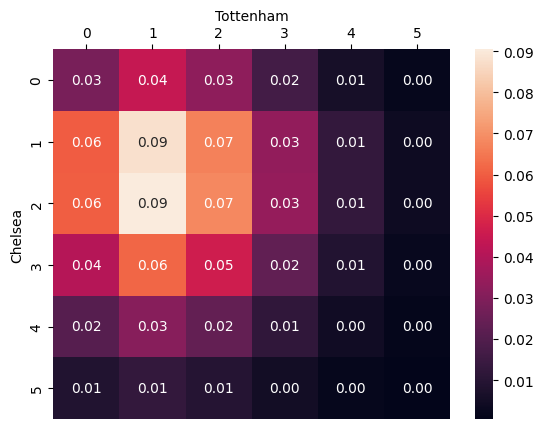

In [6]:
homeTeam = "Chelsea"
awayTeam = "Tottenham"
analyse_match(clf, homeTeam, awayTeam)

# Team ratings

In [7]:
teams = "Arsenal,Aston Villa,Bournemouth,Brentford,Brighton,Chelsea,Crystal Palace,Everton,Fulham,Ipswich,Leicester,Liverpool,Man City,Man United,Newcastle,Nott'm Forest,Southampton,Tottenham,West Ham,Wolves" 
teams = teams.split(',')

In [8]:
# Extract attack and defense parameters
params = clf.get_params()
attack_params = {k: v for k, v in params.items() if k.startswith('attack_')}
defense_params = {k: v for k, v in params.items() if k.startswith('defence_')}

# Compute median values
median_attack = np.median(list(attack_params.values()))
median_defense = np.median(list(defense_params.values()))

# Find teams with median values
median_attack_team = [team.split('attack_')[1] for team, value in attack_params.items() if value == median_attack]
median_defense_team = [team.split('defence_')[1] for team, value in defense_params.items() if value == median_defense]

print(f"Median attack value: {median_attack}, Team(s): {median_attack_team}")
print(f"Median defense value: {median_defense}, Team(s): {median_defense_team}")

Median attack value: 1.033756944801231, Team(s): ['Brighton']
Median defense value: -0.6666494330343954, Team(s): ['Tottenham']


In [9]:
ratings = []
for team in teams:
    team_attack_rating_home =  clf.predict(team, median_defense_team[0]).home_goal_expectation
    team_attack_rating_away = clf.predict(median_defense_team[0], team).away_goal_expectation
    team_attack_rating = np.mean((team_attack_rating_home, team_attack_rating_away))
    
    team_defense_rating_home = clf.predict(team, median_attack_team[0]).away_goal_expectation
    team_defense_rating_away = clf.predict(median_attack_team[0], team).home_goal_expectation
    team_defense_rating = np.mean((team_defense_rating_home, team_defense_rating_away))
    
    team_goal_difference_rating = team_attack_rating - team_defense_rating
    ratings.append((team, team_attack_rating, team_defense_rating, team_goal_difference_rating))

ratings_df = pd.DataFrame(ratings, columns=['team', 'attack_rating', 'defense_rating', 'goal_difference_rating']).sort_values(by='goal_difference_rating', ascending=False).reset_index(drop=True)
ratings_df.index += 1

dfi.export(ratings_df, "ratings.png", table_conversion='matplotlib',)

display(ratings_df)

,team,attack_rating,defense_rating,goal_difference_rating
1,Liverpool,2.319295,1.036670,1.282625
2,Arsenal,1.949845,0.769492,1.180353
3,Man City,2.209773,1.162523,1.047250
4,Chelsea,1.968729,1.259245,0.709484
5,Newcastle,1.886383,1.296788,0.589595
6,Crystal Palace,1.585478,1.129152,0.456326
7,Nott'm Forest,1.677932,1.257598,0.420334
8,Tottenham,1.857549,1.498192,0.359357
9,Bournemouth,1.579144,1.295952,0.283192
10,Brentford,1.740131,1.501787,0.238343


# Simulate season

In [10]:
league_table = pd.read_html('https://fbref.com/en/comps/9/Premier-League-Stats')[0]

In [11]:
team_name_dict = {"Nott'ham Forest": "Nott'm Forest",
                  'Manchester City': 'Man City',
                  'Manchester Utd': 'Man United',
                  'Newcastle Utd': 'Newcastle',
                  'Ipswich Town': 'Ipswich',
                  'Leicester City': 'Leicester',
                  }

In [12]:
league_table['Squad'] = league_table['Squad'].replace(team_name_dict)
league_table

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,xG,xGA,xGD,xGD/90,Last 5,Attendance,Top Team Scorer,Goalkeeper,Notes
0,1,Liverpool,30,22,7,1,70,27,43,73,2.43,66.4,26.0,40.4,1.35,D W W W W,60311,Mohamed Salah - 27,Alisson,NaN
1,2,Arsenal,30,17,10,3,55,25,30,61,2.03,46.7,25.7,21.0,0.70,L D D W W,60276,Kai Havertz - 9,David Raya,NaN
2,3,Nott'm Forest,30,17,6,7,50,35,15,57,1.90,37.0,35.6,1.4,0.05,L D W W W,30091,Chris Wood - 18,Matz Sels,NaN
3,4,Chelsea,30,15,7,8,54,37,17,52,1.73,56.9,40.3,16.6,0.55,L W W L W,39610,Cole Palmer - 14,Robert Sánchez,NaN
4,5,Man City,30,15,6,9,57,40,17,51,1.70,53.6,39.5,14.1,0.47,L W L D W,52819,Erling Haaland - 21,Ederson,NaN
5,6,Newcastle,29,15,5,9,49,39,10,50,1.72,47.5,36.9,10.6,0.37,L W L W W,52177,Alexander Isak - 20,Nick Pope,NaN
6,7,Aston Villa,30,13,9,8,44,45,-1,48,1.60,42.4,40.9,1.5,0.05,D W L W W,41958,Ollie Watkins - 13,Emiliano Martínez,NaN
7,8,Brighton,30,12,11,7,48,45,3,47,1.57,44.5,42.3,2.2,0.07,W W W D L,31888,João Pedro - 8,Bart Verbruggen,NaN
8,9,Fulham,30,12,9,9,44,40,4,45,1.50,40.8,35.2,5.6,0.19,L W L W L,26592,Raúl Jiménez - 10,Bernd Leno,NaN
9,10,Bournemouth,30,12,8,10,49,38,11,44,1.47,54.8,39.9,14.9,0.50,L L D L L,11209,Justin Kluivert - 12,Kepa Arrizabalaga,NaN


In [13]:
fpl_fixtures_data = json.loads(requests.get('https://fantasy.premierleague.com/api/fixtures/').text)
fpl_fixtures = pd.DataFrame(fpl_fixtures_data)
fpl_fixtures['home_team'] = [teams[i] for i in fpl_fixtures['team_h']-1]
fpl_fixtures['away_team'] = [teams[i] for i in fpl_fixtures['team_a']-1]
#fpl_fixtures
display(fpl_fixtures.shape)

(380, 19)

In [14]:
fixtures = fpl_fixtures[fpl_fixtures['team_h_score'].isnull()].reset_index(drop=True)
#fixtures
display(fixtures.shape)

(80, 19)

In [ ]:
nr_simulations = 10
simulation_results = []
manager_results = []
final_gameweek = 38
for i in tqdm(range(nr_simulations), desc='Simulating...'):
    simulated_table = league_table[['Rk', 'Squad', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts']].copy()
    simulated_table, manager_xp = simulate_season(league_table, fixtures, clf, final_gameweek)
    simulated_table['simulation_nr'] = i
    simulation_results.append(simulated_table)

    manager_df = pd.DataFrame(manager_xp, columns=['gameweek', 'team', 'expected_points'])
    manager_df['simulation_nr'] = i
    manager_results.append(manager_df)

print('Done!')

simulation_results_df = pd.concat(simulation_results).reset_index(drop=True)
manager_results_df = pd.concat(manager_results).reset_index(drop=True)

Simulating...: 100%|██████████| 10/10 [00:01<00:00,  8.91it/s]

Done!


In [18]:
result_matrix = (
    simulation_results_df.groupby(['Squad', 'Rk'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=range(1, 21), fill_value=0)  # Ensure columns go from 1 to 20
)

# normalize to percentage
result_matrix = 100 * (result_matrix / nr_simulations)

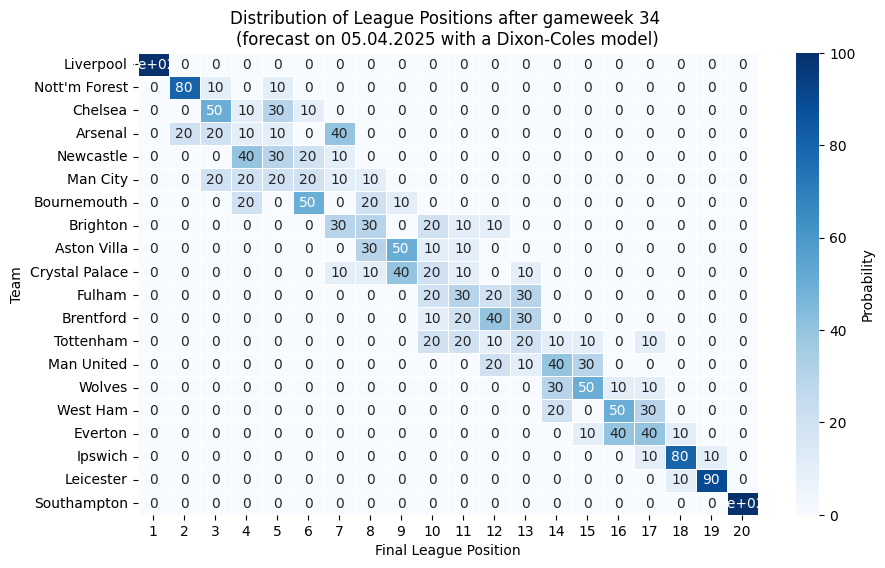

In [24]:
# Reorder the matrix based on average final league position
sorted_teams = simulation_results_df.groupby(['Squad'])['Rk'].mean().sort_values().index
sorted_matrix = result_matrix.loc[sorted_teams]

# Plot the reordered heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(sorted_matrix, annot=True, cmap="Blues", linewidths=0.5, cbar_kws={'label': 'Probability'})

timestamp = dt.datetime.now().strftime("%d.%m.%Y")
if final_gameweek == 38:
    plt.title(f"Distribution of Final League Positions \n(forecast on {timestamp} with a Dixon-Coles model)")
else:
    plt.title(f"Distribution of League Positions after gameweek {final_gameweek} \n(forecast on {timestamp} with a Dixon-Coles model)")
plt.xlabel("Final League Position")
plt.ylabel("Team")

#plt.savefig('league_distribution.png')

plt.show()